In [1]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import time

In [2]:
_ = torch.manual_seed(13)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
device

device(type='cpu')

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

In [5]:
train_set = torchvision.datasets.MNIST(
    root="data", train=True, download=True, transform=transform
)

In [6]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

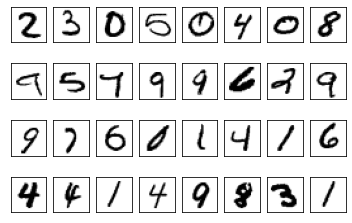

In [7]:
real_samples, mnist = next(iter(train_loader))
for (index, image) in enumerate(real_samples):
    ax = plt.subplot(4, 8, index + 1)
    plt.imshow(image.reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output


In [9]:
discriminator = Discriminator().to(device=device)
generator = Generator().to(device=device)

## Training

In [10]:
lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [ ]:
start_time = time.time()
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")
            print(f"Epoch: {epoch} Time   : {time.time() - start_time} seconds")
            start_time = time.time()
            print("")